In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cm
import pandas as pd
from scipy import stats


from dask.distributed import Client

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)




In [5]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'geouv/'

In [6]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33819 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.48 GB


In [12]:
def PlotWholeSO():
    lon1=-287
    lon2=73
    lat1=-60
    lat2=-40
    
    plt.figure(figsize=(14, 8))

    ## Other things to set
    nfiles = 50
    nn=0
    col = 'r'
    start = pd.datetime(1980,1,1) ## start time for plotting
    end = pd.datetime(2014,12,31)

    plt.figure(figsize=(7.5,6))
    ## Axes to plot EKE
    ax_eke=plt.subplot(111)
    eke_results = []
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        ekefilename = HardDisk+EnsembleDir+Member+'/eke_'+i00+'_????.nc'
        
        eke = xr.open_mfdataset(ekefilename).EKE
    
        eke = eke.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
        eke = eke.rolling(time=12,center=True).mean()
        eke.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
        result = {'ii': ii,'eke': eke}
        eke_results.append(result)
    
        if ii==1:
            eke_sum = eke
        else:
            eke_sum = eke_sum + eke
        #print(ekefilename)
                        
    eke_sum = eke_sum.load()/nn
    eke_sum.plot(ax=ax_eke,color=col,linewidth=2)
    ax_eke.set_xlabel('Year')
    ax_eke.set_ylabel('Transient KE (m$^2$/s$^2$)',color=col)
    ax_eke.set_ylim(ymax=0.013)
    ax_eke.tick_params('y',labelcolor=col)

    ax_tau=ax_eke.twinx()
    
    # Compute variance ratios from saved results
    for result in eke_results:
        ii = result['ii']
        eke = result['eke']
    
        if ii==1:
            eke_var = (eke - eke_sum)**2
        else:
            eke_var = eke_var + (eke - eke_sum)**2
        
    eke_var = eke_var.load()/nn
    sigma2 = np.var(eke_sum)  
    epsilon2 = eke_var.mean('time')
    ratio = (epsilon2/(epsilon2+sigma2))
    print(' R_i = %0.2f'%ratio.values)

    ## Axes to plot the wind
    taufilename = HardDisk+EnsembleDir+'tau/'+'tau_????.nc'
    tau = xr.open_mfdataset(taufilename).tau
    
    tau = tau.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
    tau = tau.rolling(time=12,center=True).mean()
    tau.plot(ax=ax_tau,color='k',linestyle='--',linewidth=2,label='Wind Stress')
    ax_tau.set_ylim([0.14, 0.18])
    ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
    ax_tau.set_xlim([start,end])

    ## Axes to plot lagged correlation
    ekep = eke_sum[6:-6] - eke_sum.mean()
    taup = tau[6:-6] - tau.mean()
    coef, signif = pearsoncor(taup,ekep)
    lag = coef.argmax() 

    ax_corr = plt.axes([0.18,0.68,0.2,0.22])
    ax_corr.plot(coef)
    print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef[lag], signif[lag]))

    ax_corr.plot(lag,coef[lag],'.')
    
    ax_corr.set_xlim([0,48])
    ax_corr.set_ylim([0,0.6])
    ax_corr.set_xticks([0, 12, 24, 36])
    ax_corr.set_title('Lag Correlation')
    ax_corr.set_xlabel('Months')
    #ax_corr.set_ylabel('Correlation')
    ax_corr.grid()
    
    plt.savefig('figures/ensemble_SO.png')

In [13]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries
    n = len(y1)
    nc = int(n/3.5)
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        cor[j], sig[j] = stats.pearsonr(x1t, x2t)
    return cor, sig

 R_i = 0.72
Correlations: 7 months, 0.49, 0.00


<Figure size 1008x576 with 0 Axes>

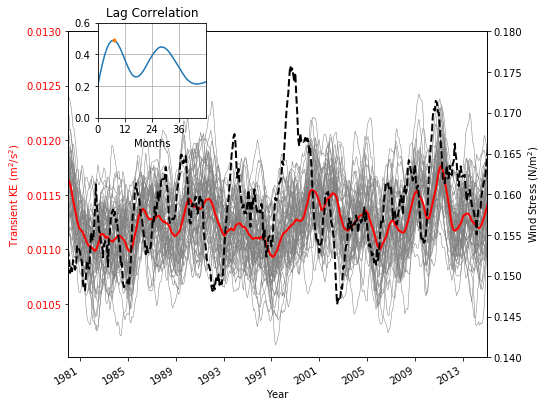

In [14]:
PlotWholeSO()